# Python Post-Processing of RocketLogger Indoor Harvesting Traces

```
Copyright (c) 2019-2020, ETH Zurich, Computer Engineering Group
All rights reserved.

This work is licensed under the Creative Commons Attribution 4.0 International License.
To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/ or
send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.
```

The file is part of the dataset entiled *"Long-Term Tracing of Indoor Solar Harvesting"* which complements the following publication:

> L. Sigrist, A. Gomez, and L. Thiele.
> *"Dataset: Tracing Indoor Solar Harvesting."*
> In Proceedings of the 2nd Workshop on Data Acquisition To Analysis (DATA '19), 2019.


The dataset is published and documented on Zenodo:

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3715472.svg)](https://doi.org/10.5281/zenodo.3715472)

**Description**

This Jupyter notebook imports the processed HDF5 dataset of the *Indoor Solar Harvesting Dataset* stored in the [`processed/`](processed/) folder. After calculating additional power and energy data columns, the data is then aggregated in 5 min intervals.
Columns-wise statistics is calculated and a joint preview of the extracted power and illuminace is plotted.
In the last part the short-term predicion performance of a few energy prediction algorithms is compared on the presented dataset.

**Python package requirements**

The following Python packages are required to run this script: `matplotlib numpy pandas tables`

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

In [2]:
DATASET_PATH = './processed'
DATASET_POSITIONS = ['pos06', 'pos13', 'pos14', 'pos16', 'pos17', 'pos18']
DATASET_TIME_REFERENCE = 'relative' # see raw data import script for more explaination

In [3]:
# load dataset for the first position
position = DATASET_POSITIONS[4]

power_df = pd.read_hdf(os.path.join(DATASET_PATH, '{:s}_power_{:s}.h5'.format(position, DATASET_TIME_REFERENCE)), 'dataset')
sensor_df = pd.read_hdf(os.path.join(DATASET_PATH, '{:s}_sensor_{:s}.h5'.format(position, DATASET_TIME_REFERENCE)), 'dataset')

# alternative: load from pickle files
# power_df = pd.read_pickle(os.path.join(DATASET_PATH, '{:s}_power_{:s}.p.bz2'.format(position, DATASET_TIME_REFERENCE)))
# sensor_df = pd.read_pickle(os.path.join(DATAFRAME_BACKUP_PATH, '{:s}_sensor_{:s}.p.bz2'.format(position, DATASET_TIME_REFERENCE)))

In [4]:
# explicitly register matplotlib time converters for pandas
register_matplotlib_converters()

In [5]:
# derive energy and average sensor columns
power_df['P_in'] = -1 * power_df.I_in * power_df.V_in
power_df['P_bat'] = power_df.I_bat * power_df.V_bat
power_df['E_in'] = power_df.dt * power_df.P_in
power_df['E_bat'] = power_df.dt * power_df.P_bat

sensor_df['Ev'] = sensor_df[['Ev_left', 'Ev_right']].mean(1)

## Dataset Info

In [6]:
# power dataframe info
power_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82300988 entries, 2017-07-27 13:28:26.523104 to 2020-03-16 18:08:41.271579
Data columns (total 9 columns):
I_bat    float64
I_in     float64
V_bat    float64
V_in     float64
dt       float64
P_in     float64
P_bat    float64
E_in     float64
E_bat    float64
dtypes: float64(9)
memory usage: 6.1 GB


In [7]:
# sensor dataframe info
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82300958 entries, 2017-07-27 13:28:26.524197 to 2020-03-16 18:08:41.271947
Data columns (total 7 columns):
Ev_left     float64
Ev_right    float64
P_amb       float64
RH_amb      float64
T_amb       float64
dt          float64
Ev          float64
dtypes: float64(7)
memory usage: 4.9 GB


## Dataset Aggregation

In [8]:
AGGREGATE_WINDOW = '5min'

In [9]:
# aggregate power data (see also: https://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)
power_agg_mean = power_df[['I_bat', 'I_in', 'V_bat', 'V_in', 'P_in', 'P_bat']].resample(AGGREGATE_WINDOW).mean()
power_agg_sum = power_df[['E_in', 'E_bat']].resample(AGGREGATE_WINDOW).sum()
power_agg_count = power_df['dt'].resample(AGGREGATE_WINDOW).count()
power_agg = pd.concat([power_agg_mean, power_agg_sum, power_agg_count.rename('count')])

In [10]:
# aggregate sensor data (see also: https://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)
sensor_agg_mean = sensor_df[['Ev_left', 'Ev_right', 'P_amb', 'RH_amb', 'T_amb', 'Ev']].resample(AGGREGATE_WINDOW).mean()
sensor_agg_count = sensor_df['dt'].resample(AGGREGATE_WINDOW).count()
sensor_agg = pd.concat([sensor_agg_mean, sensor_agg_count.rename('count')])

## Dataset Summary

In [11]:
# summary of aggregated power data
power_agg.describe()

E_bat          E_in         I_bat          I_in          P_bat  \
count  277401.000000  2.774010e+05  2.753100e+05  2.753100e+05  275310.000000   
mean        0.006558  9.540507e-03  5.238479e-06 -2.211155e-05       0.000022   
std         0.020667  2.644223e-02  1.644099e-05  4.446933e-05       0.000069   
min        -0.000891 -3.032250e-07 -7.058883e-07 -1.916946e-03      -0.000003   
25%        -0.000651  9.562263e-11 -5.159515e-07 -3.234289e-05      -0.000002   
50%        -0.000643  5.024050e-05 -5.096902e-07 -3.055585e-06      -0.000002   
75%         0.006968  9.259810e-03  5.648390e-06 -1.445351e-10       0.000024   
max         1.196733  1.341637e+00  9.484227e-04  5.175565e-09       0.003988   

               P_in          V_bat           V_in              0  
count  2.753100e+05  275310.000000  275310.000000  277401.000000  
mean   3.204455e-05       4.204683       0.487743     296.685942  
std    8.843725e-05       0.000427       0.600743      25.894772  
min   -1.010573e-09       4.203416       0.001166       0.000000  
25%    3.463333e-13       4.204387       0.002518     299.000000  
50%    2.178650e-07       4.204615       0.068913     299.000000  
75%    3.151679e-05       4.204977       0.977980     299.000000  
max    4.471340e-03       4.206014       2.334020     446.000000

In [12]:
# summary of aggregated sensor data
sensor_agg.describe()

0             Ev        Ev_left       Ev_right  \
count  277401.000000  275310.000000  275310.000000  275310.000000   
mean      296.685834     187.063690     181.333418     192.793961   
std        25.894934     305.780406     296.559645     315.566746   
min         0.000000       0.000000       0.000000       0.000000   
25%       299.000000       0.000000       0.000000       0.000000   
50%       299.000000      17.239130      17.043478      17.466555   
75%       299.000000     289.941054     281.370401     298.457358   
max       446.000000    6688.337793    6646.966555    6729.709030   

               P_amb         RH_amb          T_amb  
count  275310.000000  275310.000000  275310.000000  
mean    96149.436443       0.339619      24.969881  
std       800.780882       0.094593       1.497950  
min     92622.509245       0.136605      20.215843  
25%     95749.456702       0.264617      23.765503  
50%     96204.608761       0.316460      24.893328  
75%     96607.899445       0.406220      25.978710  
max     98474.111866       0.654899      31.160602

## Harvesting Power and Ambient Plots

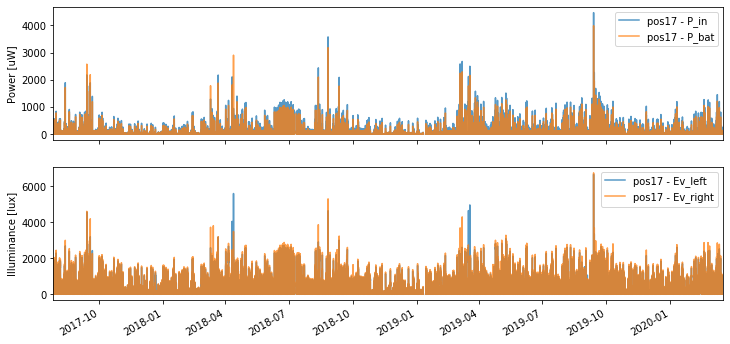

In [13]:
[f, ax] = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
_ = f.autofmt_xdate()

p1 = ax[0].plot(power_agg.index, 1e6 * power_agg[['P_in']], alpha=0.75, label='{:s} - P_in'.format(position))
p2 = ax[0].plot(power_agg.index, 1e6 * power_agg[['P_bat']], alpha=0.75, label='{:s} - P_bat'.format(position))
_ = ax[0].set(
    ylabel='Power [uW]',
    xlim=[power_agg.index.min(), power_agg.index.max()],
)
_ = ax[0].legend(loc='upper right')

p3 = ax[1].plot(sensor_agg.index, sensor_agg[['Ev_left']], alpha=0.75, label='{:s} - Ev_left'.format(position))
p4 = ax[1].plot(sensor_agg.index, sensor_agg[['Ev_right']], alpha=0.75, label='{:s} - Ev_right'.format(position))
_ = ax[1].set(
#     xlabel='time',
    ylabel='Illuminance [lux]',
)
_ = ax[1].legend(loc='upper right')

plt.show()

## Short-term Energy Prediction Accuracy

In [14]:
predict_reference = 1e6 * power_agg['P_bat']
predict = pd.DataFrame()

MA_WINDOW = 10
EWMA_SPAN = 10

In [15]:
# conservative predictor (predict currently observed value)
predict_cons = predict_reference.shift(1)
predict['CONS_abs'] = np.abs(predict_cons - predict_reference)
predict['CONS_rel'] = 100 * predict['CONS_abs'] / np.abs(predict_reference)

In [16]:
# moving average predictor
predict_ma = predict_reference.rolling(window=MA_WINDOW).mean()
predict['MA_abs'] = np.abs(predict_ma - predict_reference)
predict['MA_rel'] = 100 * predict['MA_abs'] / np.abs(predict_reference)

In [17]:
# exponentially weighted moving average predictor
predict_ewma = predict_reference.ewm(span=EWMA_SPAN).mean()
predict['EWMA_abs'] = np.abs(predict_ewma - predict_reference)
predict['EWMA_rel'] = 100 * predict['EWMA_abs'] / np.abs(predict_reference)

In [18]:
# perform statistics only for power levels higher than 10% of their average to reduce error amplification for very low values
stat_filter = predict_reference >= 0.1 * predict_reference.mean()
print(stat_filter.sum())

101867


In [19]:
predict.loc[stat_filter].describe()

CONS_abs       CONS_rel         MA_abs         MA_rel  \
count  101859.000000  101859.000000  101795.000000  101795.000000   
mean       14.829368      29.419323      23.577154      68.612552   
std        56.088451     128.463367      58.706579     202.959454   
min         0.000010       0.000104       0.000169       0.001804   
25%         1.423790       4.402058       4.490325      13.266731   
50%         3.437965      12.191850       9.678205      28.862112   
75%        10.472115      29.816561      21.583002      58.020475   
max      3885.312822   16556.191973    3551.922929   11923.164317   

            EWMA_abs       EWMA_rel  
count  101867.000000  101867.000000  
mean       19.902278      58.718542  
std        50.000000     165.285788  
min         0.000000       0.000000  
25%         3.988380      11.416416  
50%         8.561451      24.927128  
75%        18.095412      50.169185  
max      3222.331123    8495.643196

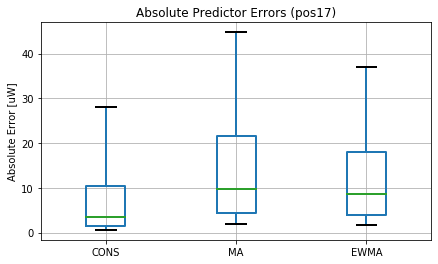

In [20]:
f = plt.figure(figsize=(7, 4))
ax, lns = predict[stat_filter].boxplot(column=['CONS_abs', 'MA_abs', 'EWMA_abs'], whis=[10,90], showfliers=False, return_type='both')
_ = ax.set(
    xticklabels=['CONS', 'MA', 'EWMA'],
    ylabel='Absolute Error [uW]',
    title='Absolute Predictor Errors ({:s})'.format(position),
)
for l in lns['whiskers'] + lns['caps'] + lns['boxes'] + lns['medians']:
    _ = l.set(linewidth=2)

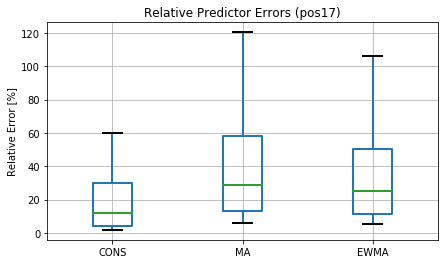

In [21]:
f = plt.figure(figsize=(7,4))
ax, lns = predict[stat_filter].boxplot(column=['CONS_rel', 'MA_rel', 'EWMA_rel'], whis=[10,90], showfliers=False, return_type='both')
_ = ax.set(
    xticklabels=['CONS', 'MA', 'EWMA'],
    ylabel='Relative Error [%]',
    title='Relative Predictor Errors ({:s})'.format(position),
)
for l in lns['whiskers'] + lns['caps'] + lns['boxes'] + lns['medians']:
    _ = l.set(linewidth=2)

## Daily Statistics per Position

In [22]:
for position in DATASET_POSITIONS:
    print('*** Power Measurement Statistics for `{:s}`:'.format(position))
    
    ## load power data
    power_df = pd.read_hdf(os.path.join(DATASET_PATH, '{:s}_power_{:s}.h5'.format(position, DATASET_TIME_REFERENCE)), 'dataset')

    # derive energy and average sensor columns
    power_df['P_in'] = -1 * power_df.I_in * power_df.V_in
    power_df['P_bat'] = power_df.I_bat * power_df.V_bat
    power_df['E_in'] = power_df.dt * power_df.P_in
    power_df['E_bat'] = power_df.dt * power_df.P_bat
    
    # aggregate power data
    power_daily = pd.concat([
            power_df[['I_bat', 'I_in', 'V_bat', 'V_in', 'P_in', 'P_bat']].resample('1d').mean(),
            power_df[['E_in', 'E_bat']].resample('1d').sum(),
        ],
        sort=True
    )
    power_daily_deviation = np.abs(power_daily - power_daily.mean())
    
    # print daily power statistics
    print('>> Aggregate daily:\n', power_daily.describe())
    print('>> Aggregate absolut deviation stats:\n', power_daily_deviation.describe())
    
    
    print('*** Sensor Measurement Statistics for `{:s}`:'.format(position))
    
    ## load power data
    sensor_df = pd.read_hdf(os.path.join(DATASET_PATH, '{:s}_sensor_{:s}.h5'.format(position, DATASET_TIME_REFERENCE)), 'dataset')

    # derive energy and average sensor columns
    sensor_df['Ev'] = sensor_df[['Ev_left', 'Ev_right']].mean(1)
    
    # aggregate power data
    sensor_daily = sensor_df[['Ev_left', 'Ev_right', 'P_amb', 'RH_amb', 'T_amb', 'Ev']].resample('1d').mean()
    power_daily_deviation = np.abs(sensor_daily - sensor_daily.mean())
    
    # print daily power statistics
    print('>> Aggregate daily:\n', sensor_daily.describe())
    print('>> Aggregate absolut deviation stats:\n', power_daily_deviation.describe())

*** Power Measurement Statistics for `pos06`:
>> Aggregate daily:
             E_bat        E_in         I_bat          I_in       P_bat  \
count  691.000000  691.000000  6.890000e+02  6.890000e+02  689.000000   
mean     1.608144    2.020564  4.465129e-06 -1.216289e-05    0.000019   
std      1.133325    1.252914  3.133576e-06  7.009484e-06    0.000013   
min     -0.200063    0.000000 -6.300470e-07 -2.756504e-05   -0.000003   
25%      0.313648    0.606863  9.001523e-07 -1.749609e-05    0.000004   
50%      1.915928    2.358828  5.286263e-06 -1.393867e-05    0.000022   
75%      2.482491    2.979397  6.887221e-06 -4.372090e-06    0.000029   
max      4.106607    4.781431  1.131487e-05 -1.357160e-07    0.000048   

               P_in       V_bat        V_in  
count  6.890000e+02  689.000000  689.000000  
mean   2.357148e-05    4.200779    0.802320  
std    1.452489e-05    0.000125    0.243503  
min    8.657343e-09    4.200420    0.063839  
25%    7.197961e-06    4.200694    0.694686  